# Weather Impact on Agricultural Commodity Prices

Importing necessary libraries:

In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from dotenv import load_dotenv

Add root directory to PATH:

In [2]:
module_path = Path().cwd().parent.as_posix()
if module_path not in sys.path:
    sys.path.append(module_path)

Importing custom functions and modules:

In [3]:
from src.price import get_commodity_data
from src.noaa import noaa_batch_data_extraction
from src.nasa import nasa_batch_data_extraction
from src.utils import load_price, data_prep
from src.data_prep import preprocess_data, save_cleaned_data
from src.data_viz import plot_time_series, plot_spectral_analysis, plot_ecm_adjustment
from src.analysis import test_stationarity, fit_arima_model, error_correction_model, regression_model, create_regression_table, rolling_window_validation

Autoreload on update:

In [4]:
%load_ext autoreload
%autoreload 2

Load environment variables from .env file:

In [5]:
load_dotenv(override=True)

True

Define and create (if not exists) data folder:

In [6]:
DATA_FOLDER = Path().cwd().parent / 'data'
DATA_FOLDER.mkdir(parents=True, exist_ok=True)

Define research time span:

In [7]:
START, END = "2010-01-01", "2025-01-01"

## Step 4: Exploratory Data Analysis

Let's perform EDA for the first set of commodities along with corresponding weather data (NASA POWER data are used as they are more reliable):
- commodity: `Soybean`
- refined product: `Soybean Oil`
- closely related product: `Soybean Meal`
- tickers: `ZS=F`, `ZL=F`, `ZM=F`
- main production states: `Iowa`, `Illinois`, `Nebraska`
- weather data privider: `NASA POWER`

In [11]:
# Load tickers dictionary.
with open(Path.cwd().parent / 'lib' / 'tickers.json', 'r') as fp:
    TICKERS = json.load( fp)

# Define states.
states = ['Iowa', 'Illinois', 'Minnesota']

# Load and concatenate data.
soy_data = data_prep(
    comoddities=list(TICKERS.keys())[3:6],
    states=states,
    tickers_dict=TICKERS,
    data_folder=DATA_FOLDER,
    data_provider='nasa'
).set_index('date')

soy_data.index = pd.to_datetime(soy_data.index)

Preprocessing data by removing ouliers and filling missing values:

In [20]:
cleaned_df, metadata = preprocess_data(df=soy_data, states=list(map(str.lower, states)), commodity='soybean')

Starting data preprocessing...
Missing values summary:
  soybean: 0.11% missing
  soybean_oil: 0.11% missing
  soybean_meal: 0.11% missing
  iowa_tmin: 0.00% missing
  iowa_tmax: 0.00% missing
  iowa_prc: 0.00% missing
  illinois_tmin: 0.00% missing
  illinois_tmax: 0.00% missing
  illinois_prc: 0.00% missing
  minnesota_tmax: 0.00% missing
  minnesota_tmin: 0.00% missing
  minnesota_prc: 0.00% missing
Processing column: soybean
Winsorized 0 outliers in soybean
Processing column: soybean_oil
Winsorized 0 outliers in soybean_oil
Processing column: soybean_meal
Winsorized 1 outliers in soybean_meal
Processing column: iowa_tmin
Winsorized 2 outliers in iowa_tmin
Processing column: iowa_tmax
Winsorized 1 outliers in iowa_tmax
Processing column: iowa_prc
Winsorized 115 outliers in iowa_prc
Processing column: illinois_tmin
Winsorized 1 outliers in illinois_tmin
Processing column: illinois_tmax
Winsorized 4 outliers in illinois_tmax
Processing column: illinois_prc
Winsorized 122 outliers in i

Saving data:

In [21]:
save_cleaned_data(cleaned_df, metadata, DATA_FOLDER / 'analysis' / 'cleaned', 'soybean')

Saved cleaned data to /Users/ivan_andriushin/PycharmProjects/MScFECapstone/data/analysis/cleaned/soybean_weather_cleaned.parquet
Saved metadata saved to /Users/ivan_andriushin/PycharmProjects/MScFECapstone/data/analysis/cleaned/soybean_weather_cleaned_metadata.json


First, let's look at commodity price spread depending on the waether anomalies:

Saved time series plot to /Users/ivan_andriushin/PycharmProjects/MScFECapstone/data/analysis/results/time_series_soybean_spread_illinois_temp_anomaly_30d.png


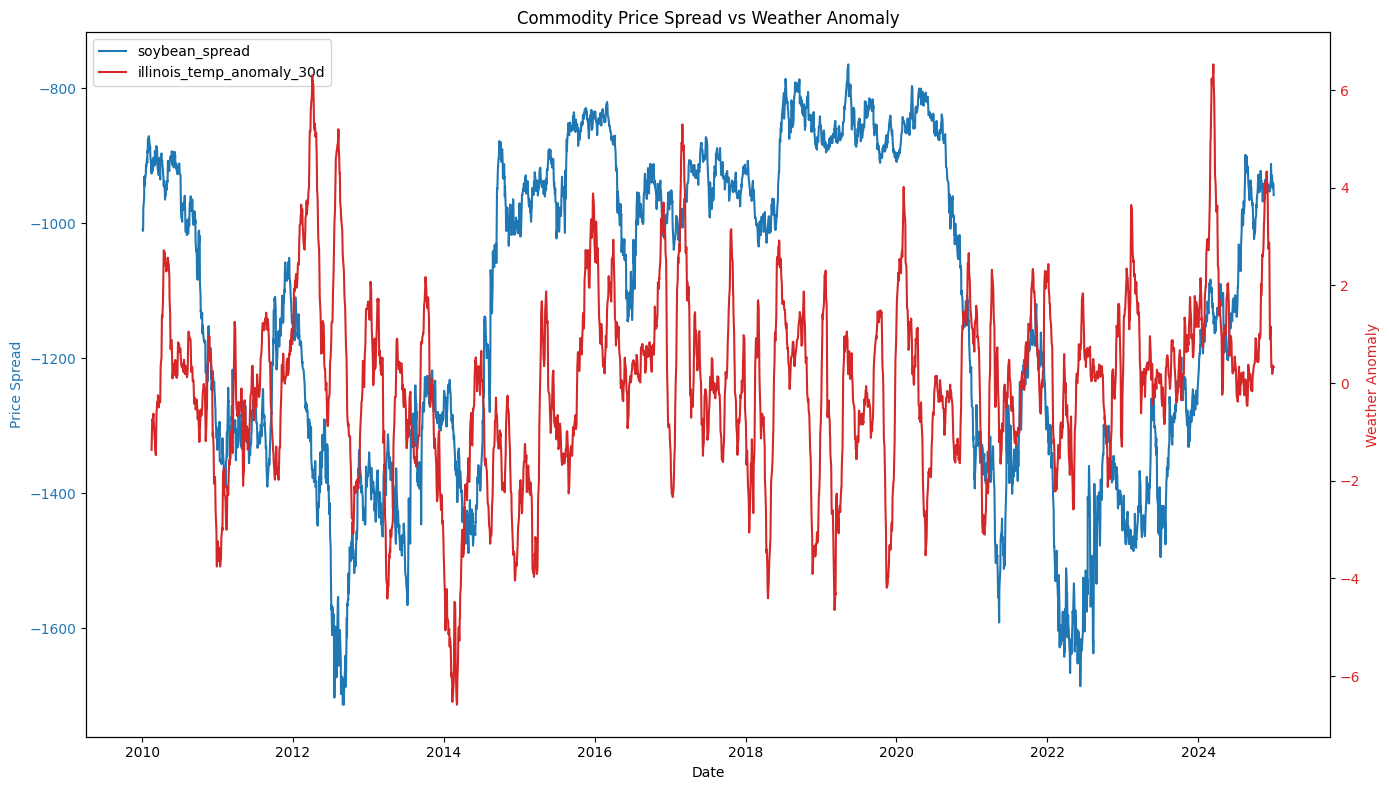

In [23]:
plot_time_series(df=cleaned_df, data_folder=DATA_FOLDER / 'analysis' / 'results', spread_col='soybean_spread', anomaly_col='illinois_temp_anomaly_30d')

Now let's plot spectral analysis for soy data as well:

Saved spectral analysis plot to /Users/ivan_andriushin/PycharmProjects/MScFECapstone/data/analysis/results/spectral_analysis_soybean_spread.png


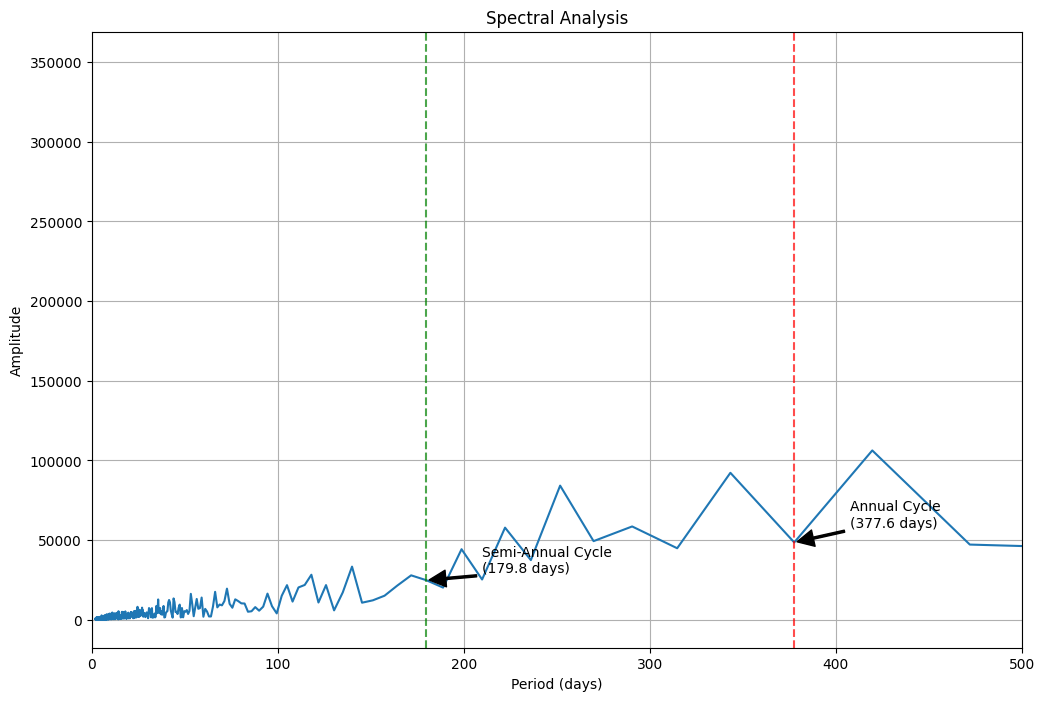

Top 5 dominant periods for soybean_spread: [ 343.27272727  419.55555556 1888.         1258.66666667 3776.        ] days


In [24]:
dominant_periods = plot_spectral_analysis(cleaned_df, data_folder=DATA_FOLDER / 'analysis' / 'results', column='soybean_spread')

Soybean-soybean oil spread has lower oscillations on both six‐month and twelve‐month cycles (comparing to corn), however we can still see the planting/harvest seasons.

## Step 5: Time Series Analysis

First of all we check time series stationarity wuth Augmented Dickey-Fuller test:

In [25]:
for col in ['soybean', 'soybean_oil', 'soybean_spread']:
    if col in cleaned_df.columns:
        print(f"\nStationarity Test for {col}:")
        test_stationarity(cleaned_df[col])


Stationarity Test for soybean:
ADF Statistic: -2.1114
p-value: 0.2400
Critical Values:
	1%: -3.4321
	5%: -2.8623
	10%: -2.5672
Series is non-stationary (p-value > 0.05)

Stationarity Test for soybean_oil:
ADF Statistic: -1.8355
p-value: 0.3630
Critical Values:
	1%: -3.4321
	5%: -2.8623
	10%: -2.5672
Series is non-stationary (p-value > 0.05)

Stationarity Test for soybean_spread:
ADF Statistic: -2.1524
p-value: 0.2240
Critical Values:
	1%: -3.4321
	5%: -2.8623
	10%: -2.5672
Series is non-stationary (p-value > 0.05)


Then apply ARIMA model for corn data:

In [26]:
# Fit ARIMA model for corn spread.
if 'soybean_spread' in cleaned_df.columns:
    arima_model = fit_arima_model(cleaned_df['soybean_spread'])

ADF Statistic: -2.1524
p-value: 0.2240
Critical Values:
	1%: -3.4321
	5%: -2.8623
	10%: -2.5672
Series is non-stationary (p-value > 0.05)
Series is not stationary, differencing will be applied
Best ARIMA order: (3, 1, 3) with AIC: 32082.9490
ARIMA Model Summary for soybean_spread:
                               SARIMAX Results                                
Dep. Variable:         soybean_spread   No. Observations:                 3776
Model:                 ARIMA(3, 1, 3)   Log Likelihood              -16034.474
Date:                Wed, 21 May 2025   AIC                          32082.949
Time:                        00:26:33   BIC                          32126.602
Sample:                             0   HQIC                         32098.468
                               - 3776                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------

Now let's perform cointegration analysis:


Cointegration Analysis for Corn and Corn Oil:
Johansen Cointegration Test for ['soybean', 'soybean_oil']:
Trace Statistics:
 [18.0614571  3.4797695]
Critical Values (5%): [15.4943  3.8415]
Cointegration Rank: 1

Vector Error Correction Model (VAR on diffs) Summary:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 21, May, 2025
Time:                     00:45:55
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    4.89948
Nobs:                     3774.00    HQIC:                   4.89309
Log likelihood:          -19930.7    FPE:                    132.895
AIC:                      4.88956    Det(Omega_mle):         132.684
--------------------------------------------------------------------
Results for equation soybean
                    coefficient       std. error           t-stat            prob
---------------------------------

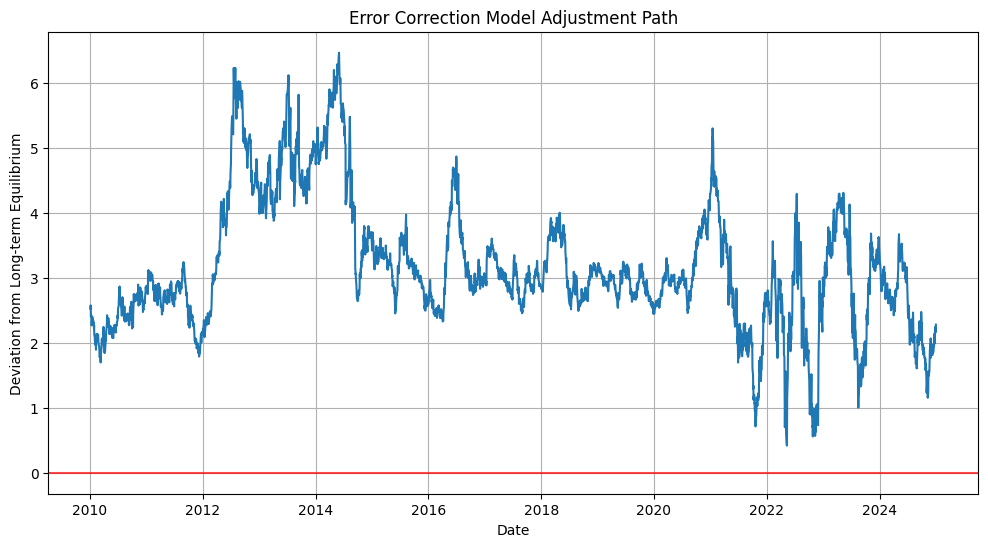

In [31]:
# Cointegration and error correction model
if all(col in cleaned_df.columns for col in ['soybean', 'soybean_oil']):
    print("\nCointegration Analysis for Soybeans and Soybean Oil:")
    var_results, ec_series = error_correction_model(cleaned_df, ['soybean', 'soybean_oil'])

    if ec_series is not None:
        plot_ecm_adjustment(cleaned_df, DATA_FOLDER / 'analysis' / 'results', ec_series, commodity='soybean')

The ECM results suggest a cointegrating relationship between soybean and soybean oil and the error correction term remains positive. This implies that the long-run equilibrium does not falls toward zero, but represents a persistent premium of soybean prices over soybean oil. Despite this asymmetry, the system is centered around this long-term difference consistent with the ECM setting for describing their joint dynamics.

## Step 6: Regression Analysis

Let's perform regression analysis:

After searching for best set of independatn variables to fit to the model we come to a conclusion that:
1) 'iowa_temp_anomaly_30d', 'iowa_prc_anomaly_30d', 'illinois_temp_anomaly_30d', 'illinois_prc_anomaly_30d', 'minnesota_temp_anomaly_30d' - show the most impact on target variable while being statistically significant;
2) weather conditions in the states under consideration, have significantly larger impact on soybeans prices comparing to corn prices - about 21% of variance can be described by weather anomalies.

In [33]:
# Regression analysis with weather variables.
if 'soybean_spread' in cleaned_df.columns:
    # Define weather variables.
    # weather_vars = [col for col in cleaned_df.columns if 'anomaly' in col]
    weather_vars = ['iowa_temp_anomaly_30d', 'iowa_prc_anomaly_30d', 'illinois_temp_anomaly_30d', 'illinois_prc_anomaly_30d', 'minnesota_temp_anomaly_30d']

    if weather_vars:
        print("\nRegression Analysis of Price Spread vs Weather Anomalies:")
        reg_results, coef_df = regression_model(cleaned_df, 'soybean_spread', weather_vars, lags=0)
        create_regression_table(reg_results, DATA_FOLDER / 'analysis' / 'results', filename='soybean_regression_results.csv')

        # Validation.
        print("\nPerforming Rolling Window Validation:")
        validation_df, avg_metrics = rolling_window_validation(cleaned_df, DATA_FOLDER / 'analysis' / 'results', 'soybean_spread', weather_vars, filename='soybean_validation_results.csv')


Regression Analysis of Price Spread vs Weather Anomalies:
Regression Model for soybean_spread:
                            OLS Regression Results                            
Dep. Variable:         soybean_spread   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     205.5
Date:                Wed, 21 May 2025   Prob (F-statistic):          4.26e-194
Time:                        00:58:20   Log-Likelihood:                -25319.
No. Observations:                3747   AIC:                         5.065e+04
Df Residuals:                    3741   BIC:                         5.069e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------